In [57]:
%%bash
dev=/home/peterr/macocu/task5_webgenres/data/final/fasttext1/dev_onlykeep_False_onlyprimary_True_dedup_False.fasttext
test=/home/peterr/macocu/task5_webgenres/data/final/fasttext1/test_onlykeep_False_onlyprimary_True_dedup_False.fasttext

destination=/home/peterr/macocu/task5_webgenres/data/final/fasttext1/devtest_onlykeep_False_onlyprimary_True_dedup_False.fasttext

cat $dev $test > $destination


In [58]:
import os
import parse
import fasttext
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
datadir = "/home/peterr/macocu/task5_webgenres/data/final/fasttext1"

dev_full = os.path.join(datadir, "dev_onlykeep_False_onlyprimary_True_dedup_False.fasttext")
test_full = os.path.join(datadir, "test_onlykeep_False_onlyprimary_True_dedup_False.fasttext")
train_full = os.path.join(datadir, "train_onlykeep_False_onlyprimary_True_dedup_False.fasttext")
devtest_full = os.path.join(datadir, "devtest_onlykeep_False_onlyprimary_True_dedup_False.fasttext")

train_labels = ['__label__Legal/Regulation',
 '__label__Opinionated_News',
 '__label__News/Reporting',
 '__label__Forum',
 '__label__Correspondence',
 '__label__Invitation',
 '__label__Instruction',
 '__label__Recipe',
 '__label__Opinion/Argumentation',
 '__label__Promotion_of_Services',
 '__label__Promotion',
 '__label__List_of_Summaries/Excerpts',
 '__label__Promotion_of_a_Product',
 '__label__Call',
 '__label__Review',
 '__label__Other',
 '__label__Information/Explanation',
 '__label__Interview',
 '__label__Prose',
 '__label__Research_Article',
 '__label__Announcement']

STR_TO_NUM = {s: i for i, s in enumerate(train_labels)}
NUM_TO_STR = {i: s for i, s in enumerate(train_labels)}


def parse_fasttext_file(path: str, encode=True):
    """Reads fasttext formatted file and returns dataframe."""
    with open(path, "r") as f:
        content = f.readlines()
    pattern = "{label} {text}\n"
    p = parse.compile(pattern)

    labels, texts = list(), list()
    for line in content:
        rez = p.parse(line)
        if rez is not None:
            labels.append(rez["label"])
            texts.append(rez["text"])
        else:
            print("error parsing line ", line)
    if encode:
        labels = [STR_TO_NUM[i] for i in labels]
    return pd.DataFrame(data={"text": texts, "labels": labels})


def plot_cm(y_true, y_pred, labels, save=False, title=None):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import f1_score
    import matplotlib.pyplot as plt
    cm = confusion_matrix(y_true, y_pred, labels=labels, )
    # print(cm)
    plt.figure(figsize=(9, 9))
    plt.imshow(cm, cmap="Oranges")
    for (i, j), z in np.ndenumerate(cm):
        plt.text(j, i, '{:d}'.format(z), ha='center', va='center')
    classNames = labels
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=90)
    plt.yticks(tick_marks, classNames)
    microF1 = f1_score(y_true, y_pred, labels=labels, average ="micro")
    macroF1 = f1_score(y_true, y_pred, labels=labels, average ="macro")

    print(f"{microF1=:0.4}")
    print(f"{macroF1=:0.4}")

    metrics = f"{microF1=:0.4}, {macroF1=:0.4}"
    if title:
        plt.title(title +";\n" + metrics)
    else:
        plt.title(metrics)
    plt.tight_layout()
    if save:
        plt.savefig(save)
    plt.show()
    return microF1, macroF1

train_df = parse_fasttext_file(train_full)
test_df = parse_fasttext_file(devtest_full)

In [59]:
test_df.labels.unique().shape

(21,)

In [60]:
train_df.labels.unique().shape

(21,)

In [64]:
from simpletransformers.classification import ClassificationModel
NUM_EPOCHS = 50
model_args = {
    "num_train_epochs": NUM_EPOCHS,
    "learning_rate": 1e-5,
    "overwrite_output_dir": True,
    "train_batch_size": 32,
    "no_save": True,
    "no_cache": True,
    "overwrite_output_dir": True,
    "save_steps": -1,
    "max_seq_length": 256
}

model = ClassificationModel(
    "camembert", "EMBEDDIA/sloberta",
    num_labels = 21,
    use_cuda = True,
    args = model_args
)
model.train_model(train_df)

Some weights of the model checkpoint at EMBEDDIA/sloberta were not used when initializing CamembertForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at EMBEDDIA/sloberta and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.bias', 

(3900, 0.36579918555724317)

In [65]:
y_true_enc = test_df.labels
y_pred_enc = model.predict(test_df.text.tolist())[0]

y_true = [NUM_TO_STR[i] for i in y_true_enc]
y_pred = [NUM_TO_STR[i] for i in y_pred_enc]



microF1=0.6292
macroF1=0.5535


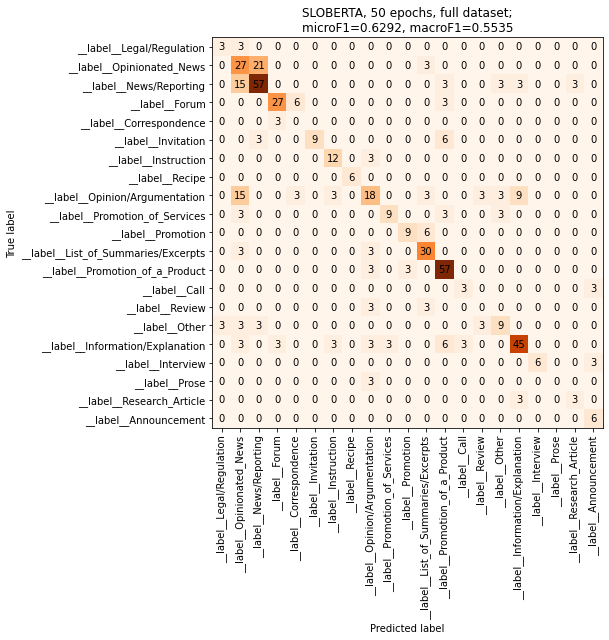

(0.6292134831460674, 0.5534780131007384)

In [66]:

plot_cm(y_true, y_pred, train_labels,
    save=f"images/SLOBERTA_{NUM_EPOCHS}_epochs_full_ds.png", 
    title =f"SLOBERTA, {NUM_EPOCHS} epochs, full dataset")